In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf
from scipy.io import loadmat

In [17]:
eddir = '/glade/scratch/wriggles/archive/'
exampleds = xr.open_dataset('/glade/work/lettier/GRIDS/cesm1_tarea.nc')
x = loadmat('/glade/work/lettier/fromMITCH/seaice/ice_grid_regions.mat')
exampleds = exampleds.rename({'nlon':'ni','nlat':'nj'})
exampleds['TAREA'] = exampleds['TAREA']/1e4 # convert to m^2 from cm^2
print([f for f in x])
region_mask = x['ifXY_reg']
region_list =   [f[0] for f in x['reg_list'][0]]
print(region_list)
model_regions  = xr.DataArray(region_mask, dims=('ni','nj','region'), 
                              coords = {'ni' : exampleds.ni.values, 'nj' : exampleds.nj.values , 'region' : region_list[:16]} )

['__header__', '__version__', '__globals__', 'x', 'y', 'ifXY', 'w', 'ifXY_reg', 'reg_list']
['Central Arctic', 'GIN Seas', 'Barents Sea', 'Kara Sea', 'Laptev Sea', 'East Siberian Sea', 'Chukchi Sea', 'Bering Sea', 'Sea of Okhotsk', 'Beaufort Sea', 'Canadian Archipelago', 'Hudson Bay', 'Baffin Bay', 'Labrador Sea', 'Open Ocean', 'Pan Arctic', 'Barents GIN', 'Kara Laptev East Siberian', 'Chukchi Bering Okhotsk', 'CAA HB BB Lab']


In [3]:
def calc_reg_sia_nh (ds, ints, model_regions, tarea):
    sia = (tarea*model_regions*ds.aice/100./1e12).sum(dim=('ni','nj')).to_dataset(name='sia_nh_reg')
    sie = (tarea*model_regions*ints/1e12).sum(dim=('ni','nj')).to_dataset(name='sie_nh_reg')
    if 'hi' in ds:
        siv = (tarea*model_regions*ds.aice/100.*ds.hi/1e12).sum(dim=('ni','nj')).to_dataset(name='siv_nh_reg')
        outds = xr.merge([sia,sie,siv])
    else:
        outds = xr.merge([sia,sie])
    return outds

In [4]:
mydir = '/glade/work/lettier/NUDGE/'

In [5]:
def calc_siasivsie (ds, name, hemi='nhsh'):
    
    mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')
    ds['time'] = mytime[:len(ds.time)]

    ints = ds.aice.copy()
    ints = ints.where(ints>15.)
    ints = ints.where(ints!=ints,1.)

    varlist = []
    if 'nh' in hemi:
        sia_nh = ((ds.aice/100.*ds.tarea).where(ds.TLAT>0.).sum(dim=('ni','nj'))/1e12).to_dataset(name='sia_nh')
        sie_nh = ((ints*ds.tarea).where(ds.TLAT>0.).sum(dim=('ni','nj'))/1e12).to_dataset(name='sie_nh')
        rds = calc_reg_sia_nh(ds, ints, model_regions, ds.tarea )
        varlist.append(sia_nh)
        varlist.append(sie_nh)
        varlist.append(rds)
        
        if 'hi' in ds:
            siv_nh = ((ds.aice/100.*ds.hi*ds.tarea).where(ds.TLAT>0.).sum(dim=('ni','nj'))/1e12).to_dataset(name='siv_nh')
            varlist.append(siv_nh)  
 
    if 'sh' in hemi:
        sia_sh = ((ds.aice/100.*ds.tarea).where(ds.TLAT<0.).sum(dim=('ni','nj'))/1e12).to_dataset(name='sia_sh')
        sie_sh = ((ints*ds.tarea).where(ds.TLAT<0.).sum(dim=('ni','nj'))/1e12).to_dataset(name='sie_sh')
        varlist.append(sia_sh)
        varlist.append(sie_sh)
        
        if 'hi' in ds:
            siv_sh = ((ds.aice/100.*ds.hi*ds.tarea).where(ds.TLAT<0.).sum(dim=('ni','nj'))/1e12).to_dataset(name='siv_sh')
            varlist.append(siv_sh)

    ds = xr.merge(varlist)
    ds['names'] = name
    ds = ds.set_coords('names')
    
    for var in ds:
        if 'sie' in var or 'sia' in var:
            ds[var].attrs['units'] = 'million km^2'
        elif 'siv' in var:
            ds[var].attrs['units'] = '10^3 km^3'

    ds.attrs['desc'] = 'processed by Lettie Roach, Nov 2021'
    ds.to_netcdf(mydir+'processed/siasivsie/'+name+'.siasivsie_'+hemi+'.1979-2018.nc')
    
    return ds

In [6]:
def wrangle_nudge (nudge_name, myvariables):
    ds_a = xr.open_mfdataset(eddir+nudge_name+'/ice/hist/*.h.*')[myvariables]
    ds_b = xr.open_mfdataset(eddir+nudge_name+'_21C/ice/hist/*.h.*')[myvariables]
    ds = xr.concat([ds_a,ds_b],dim='time')
 
    ds['names'] = nudge_name
    ds = ds.set_coords('names')
    
    return ds

In [7]:
for name in ['anom_nudge_era_60_arclo','anom_nudge_era_60_archi','anom_nudge_era_60']:
    ds = calc_siasivsie (wrangle_nudge(name, ['aice','hi','tarea']), name)

OSError: no files to open

In [10]:
model_regions = model_regions.isel(nj=slice(-104,None))
ledir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/'
listds = []
for e in range(1,2,1):
    ens = str(e)
    if e<10:
        ens = '0'+str(e)
    tmp = []
    for var in ['aice','hi']:
        myfiles = sorted([ledir+var+'/'+f for f in os.listdir(ledir+var) if ('B20TRC5CNBDRD' in f or 'BRCP85C5CNBDRD' in f) and '0'+ens+'.cice.h.'+var+'_nh' in f ])
        myfiles = [f for f in myfiles if '.192001-199912.nc' not in f and '208101-210012.nc' not in f]
        ds = xr.open_mfdataset(myfiles).sel(time=slice('1979-02','2019-01'))
        tmp.append(ds)
    ds = xr.merge(tmp)

    ds = calc_siasivsie (ds, 'LENS-'+ens, hemi = 'nh')
    nhds = ds.copy()
    
    tmp = []
    for var in ['aice','hi']:
        myfiles = sorted([ledir+var+'/'+f for f in os.listdir(ledir+var) if ('B20TRC5CNBDRD' in f or 'BRCP85C5CNBDRD' in f) and '0'+ens+'.cice.h.'+var+'_sh' in f ])
        myfiles = [f for f in myfiles if '.192001-199912.nc' not in f and '208101-210012.nc' not in f]
        ds = xr.open_mfdataset(myfiles).sel(time=slice('1979-02','2019-01'))
        tmp.append(ds)
    ds = xr.merge(tmp)
    ds = calc_siasivsie (ds, 'LENS-'+ens, hemi = 'sh')

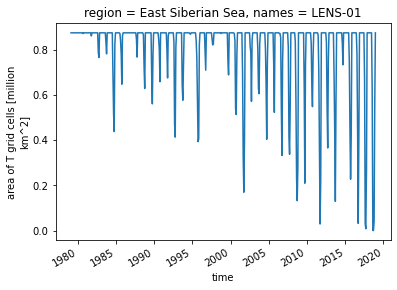

In [15]:
nhds.sie_nh_reg.isel(region=5).plot()

# CDRv4

In [18]:
# on original grid
ds = xr.open_dataset('/glade/work/lettier/CDRv4/mon/processed/sia_cdr_monthly_nhsh_197811-202105_v04r00.nc')
ds = ds.sel(time=slice('1979','2018'))

for var in ['cdr','nt','bt']:
    obds = ds[[f for f in ds if var in f and 'nh' in f]]
    obds['names'] = 'OBS-CDRv4-'+var
    obds = obds.set_coords('names')
    obds = obds.rename({'sie_nh_'+var:'sie_nh','sia_nh_'+var:'sia_nh'})
    obds.to_netcdf('/glade/work/lettier/archived_data/202203_data_paper_nudge_arctic_winds/sia_sie_siv_timeseries/cdrv4_orig_grid/OBS-CDRv4-'+var+'.siasivsie_nh.1979-2018.nc')

Compute regional SIE on CESM grid

In [19]:
ds = xr.open_mfdataset('/glade/work/lettier/CDRv4/mon/nhdl/remap_cesmgrid/*.nc',concat_dim='tdim',combine='nested')
mytime = ds.time.values
ds = ds.drop('time')
ds['tdim'] = mytime
ds = ds.rename({'tdim':'time'})

ds = ds.sel(time=slice('1979','2018'))
ds['time'] = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')

In [20]:
obvars = ['cdr_seaice_conc_monthly','nsidc_bt_seaice_conc_monthly','nsidc_nt_seaice_conc_monthly']
mynames =['OBS-CDRv4-'+var for var in ['cdr','bt','nt']]

In [21]:
for v, var in enumerate(obvars):
    obds = ds[[var]]
    obds[var] = obds[var].where(obds[var]<=1.) # keep only valid data
    obds[var] = obds[var]*100.
    obds['names'] = mynames[v]+'_remapcesmgrid'
    obds = obds.set_coords('names')
    obds = obds.rename({var:'aice'})
    obds = obds.rename({'nlon':'ni','nlat':'nj'})
    obds['tarea'] = exampleds.TAREA#xr.DataArray(exampleds.TAREA.values, dims= ['nlat','nlon'])
    calc_siasivsie(obds,name=mynames[v]+'_remapcesmgrid', hemi='nh')
    